In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, roc_auc_score

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import re

In [101]:
#df here contains the merger of 2 files => 1 kaggle dataset, along with the spotify parameters and lyric sentiments

df=pd.read_csv(r"C:\Users\vikra\Downloads\data_final_weighted.csv")
print(df.shape)
df.head()

(736, 62)


,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,weighted_mode,weighted_speechiness,weighted_acousticness,weighted_instrumentalness,weighted_liveness,weighted_valence,weighted_metric_depression,weighted_metric_anxiety,weighted_metric_ocd,weighted_metric_insomnia
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,0.505903,0.107372,0.151318,0.018356,0.147635,0.478043,0.109035,0.299805,0.006044,0.157349
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,0.536899,0.071132,0.264370,0.050671,0.146198,0.426144,0.102509,0.238026,0.007354,0.119117
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,0.450102,0.091677,0.133269,0.055170,0.158668,0.425012,0.115533,0.337274,0.012336,0.186468
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,0.499506,0.049079,0.288313,0.043454,0.127870,0.380871,0.096119,0.192515,0.001754,0.102004
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,0.500988,0.117007,0.157398,0.012871,0.153560,0.475373,0.088213,0.257676,0.003419,0.135539


In [102]:
df.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Fav genre',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Permissions', 'Frequency [Classical]_nor', 'Frequency [Country]_nor',
       'Frequency [EDM]_nor', 'Frequency [Folk]_nor', 'Frequency [Gospel]_nor',
       'Frequency [Hip hop]_nor', 'Frequency [Jazz]_nor',
       'Frequency [K pop]_nor', 'Frequency [Latin]_nor',
       'Frequency [Lofi]_nor', 'Frequency [Metal]_nor', 'Frequency [Pop]_nor',
       'Fr

# Remove outliers

In [103]:
numerical_columns = df.select_dtypes(include=np.number).columns

z_scores = df[numerical_columns].apply(lambda x: np.abs((x - x.mean()) / x.std()))
threshold = 3
outliers = z_scores > threshold

# Print outliers for each numerical column
for column in numerical_columns:
    column_outliers = df[outliers[column]][column]
    if not column_outliers.empty:
        print(f"Outliers in numerical column '{column}':")
        print(column_outliers)
        print()


Outliers in numerical column 'Age':
1      63.0
229    64.0
376    64.0
415    69.0
428    72.0
429    73.0
470    63.0
475    67.0
476    70.0
490    71.0
494    74.0
513    63.0
514    64.0
523    65.0
527    80.0
532    67.0
539    67.0
567    68.0
695    89.0
Name: Age, dtype: float64

Outliers in numerical column 'Hours per day':
18     24.0
290    20.0
347    16.0
359    15.0
366    24.0
407    14.0
426    13.0
485    15.0
695    24.0
726    18.0
Name: Hours per day, dtype: float64

Outliers in numerical column 'BPM':
568    999999999.0
Name: BPM, dtype: float64

Outliers in numerical column 'Frequency [Gospel]':
58     3
170    3
382    3
429    3
483    3
491    3
501    3
533    3
554    3
567    3
576    3
594    3
595    3
728    3
Name: Frequency [Gospel], dtype: int64

Outliers in numerical column 'Frequency [Classical]_nor':
34     0.500000
206    0.428571
384    0.600000
408    1.000000
411    0.428571
418    0.428571
476    0.400000
627    0.750000
635    0.428571
671  

Outliers:
- more than 12 hours a day is an outlier
- more than 70 years old is an outlier
- BPM has an error value of 999999999.0, so we drop this and check again

In [104]:
# Drop rows containing BPM outliers
df = df.drop(df[df['BPM'] == 999999999.0].index)

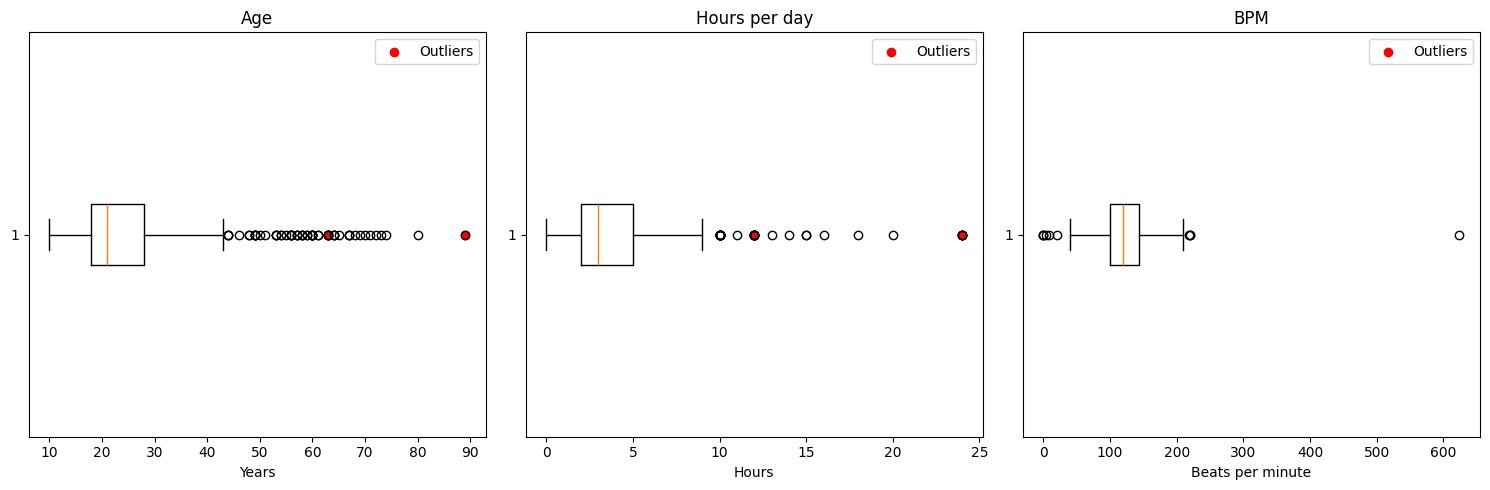

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].boxplot(df['Age'].dropna(), vert=False, showfliers=True)
axes[0].scatter(df['Age'].loc[df['Age'].isin([63, 89])], [1]*len(df['Age'].loc[df['Age'].isin([63, 89])]), color='red', label='Outliers')
axes[0].set_title('Age')
axes[0].set_xlabel('Years')
axes[0].legend()

axes[1].boxplot(df['Hours per day'].dropna(), vert=False, showfliers=True)
axes[1].scatter(df['Hours per day'].loc[df['Hours per day'].isin([12, 24])], [1]*len(df['Hours per day'].loc[df['Hours per day'].isin([12, 24])]), color='red', label='Outliers')
axes[1].set_title('Hours per day')
axes[1].set_xlabel('Hours')
axes[1].legend()

axes[2].boxplot(df['BPM'].dropna(), vert=False, showfliers=True)
axes[2].scatter(df['BPM'].loc[df['BPM'].isin([999999999.0])], [1]*len(df['BPM'].loc[df['BPM'].isin([999999999.0])]), color='red', label='Outliers')
axes[2].set_title('BPM')
axes[2].set_xlabel('Beats per minute')
axes[2].legend()

plt.tight_layout()
plt.show()


While there are some songs that are considered outliers from the boxplot, there are songs that go over 200 BPM, so we opt to drop only those above 300

In [106]:
bpm_above_200_count = df[df['BPM'] > 300]['BPM'].count()

# Print the count
print("Number of BPM values above 200:", bpm_above_200_count)

Number of BPM values above 200: 1


In [107]:
df = df.drop(df[df['BPM'] > 300].index)
df = df.drop(df[df['Age'] > 70].index)
df = df.drop(df[df['Hours per day'] > 12].index)

# imputation 

In [108]:
null_counts = df.isnull().sum()

columns_with_nulls = null_counts[null_counts > 0]

for column, null_count in columns_with_nulls.items():
    print(f"Column '{column}' has {null_count} null values.")


Column 'Age' has 1 null values.
Column 'Primary streaming service' has 1 null values.
Column 'While working' has 2 null values.
Column 'Instrumentalist' has 4 null values.
Column 'Composer' has 1 null values.
Column 'Foreign languages' has 4 null values.
Column 'BPM' has 105 null values.
Column 'Music effects' has 8 null values.


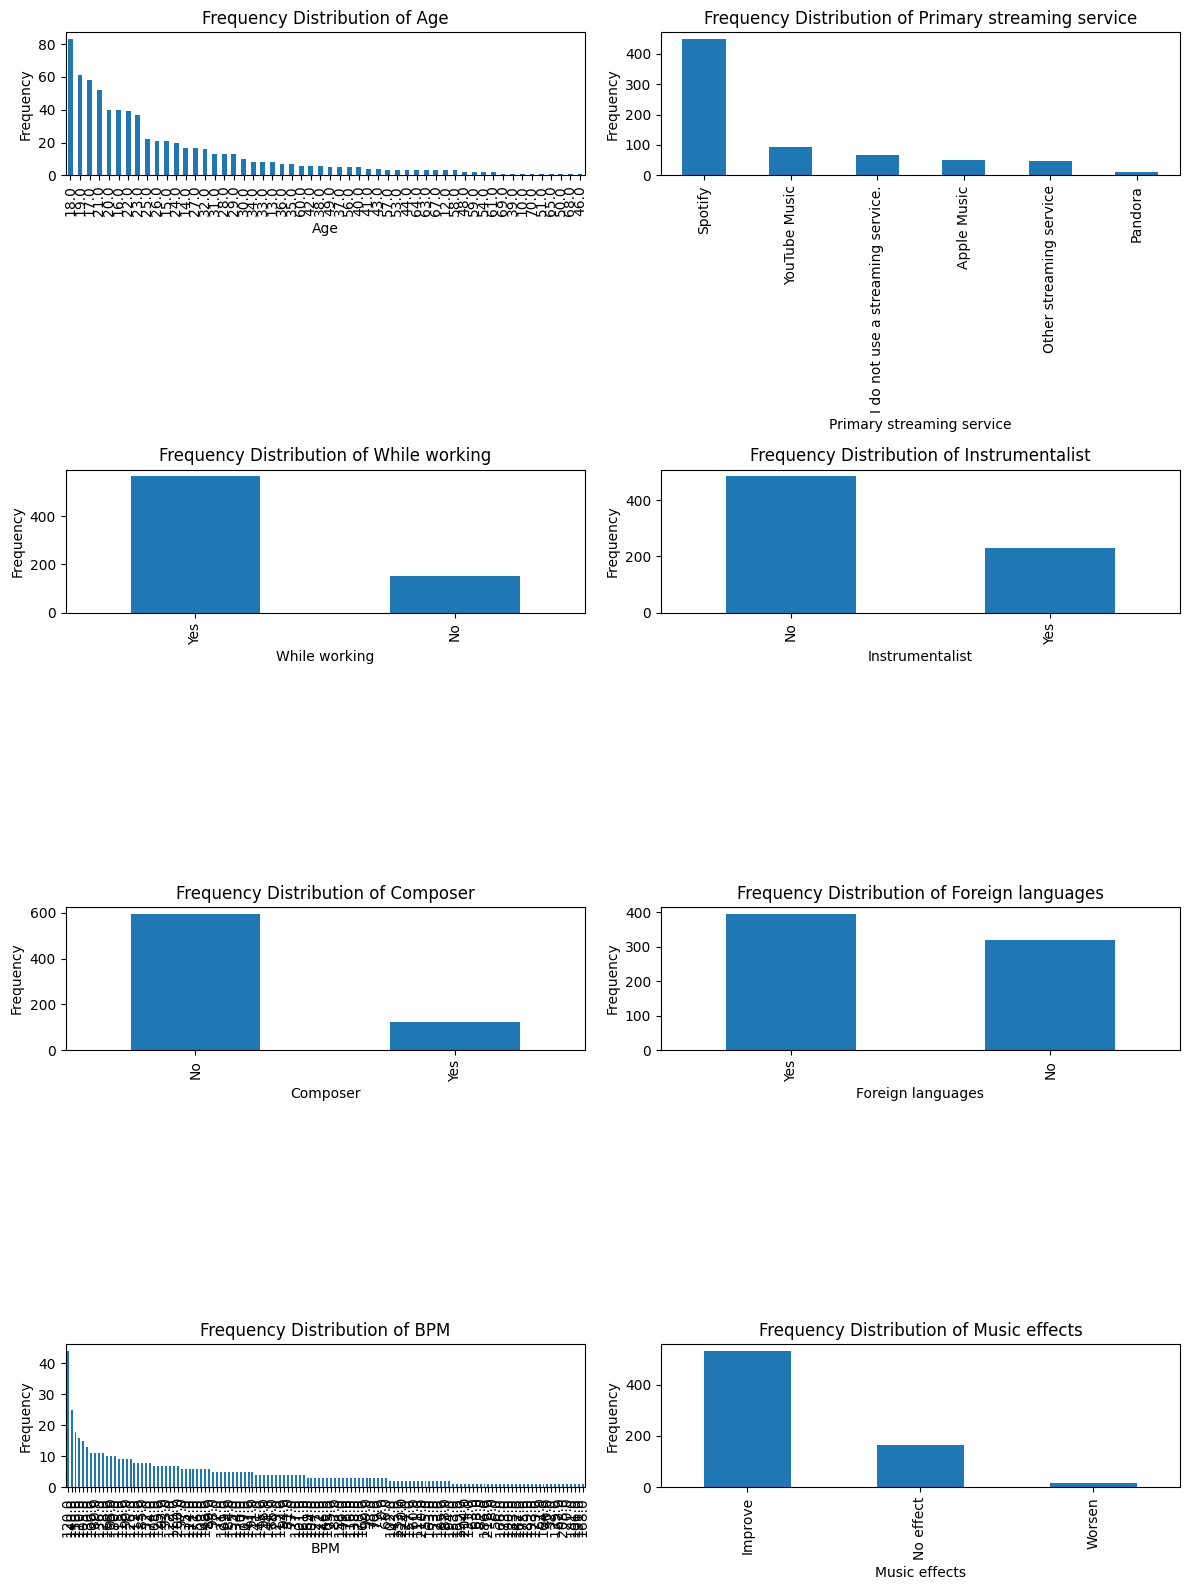

In [109]:
columns_of_interest = [
    'Age',
    'Primary streaming service',
    'While working',
    'Instrumentalist',
    'Composer',
    'Foreign languages',
    'BPM',
    'Music effects'
]
df_filtered = df[columns_of_interest]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

for i, column in enumerate(df_filtered.columns):
    ax = axes[i//2, i%2]
    df_filtered[column].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Frequency Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


- Mean for normal imputation
- Median for skewed
- Mode for categorical

- Since age is skewed => Median
- Composer, while working, instrumentalist, Primary streaming service with mode
- Music effects,BPM and foreign languages with Random forest regressor due to even distribution and higher number of missing values.



Column 'Foreign languages' has 20 null values.
Column 'BPM' has 1997 null values.
Column 'Music effects' has 142 null values.

In [110]:
# Fill missing values in 'Age' with median
median_age = df['Age'].median()
df['Age'].fillna(median_age, inplace=True)

# Fill missing values in 'Composer', 'While working', 'Instrumentalist', and 'Primary streaming service' with mode
mode_composer = df['Composer'].mode()[0]
mode_while_working = df['While working'].mode()[0]
mode_instrumentalist = df['Instrumentalist'].mode()[0]
mode_primary_streaming_service = df['Primary streaming service'].mode()[0]

df['Composer'].fillna(mode_composer, inplace=True)
df['While working'].fillna(mode_while_working, inplace=True)
df['Instrumentalist'].fillna(mode_instrumentalist, inplace=True)
df['Primary streaming service'].fillna(mode_primary_streaming_service, inplace=True)

In [111]:
columns_with_nas = df.columns[df.isna().any()]
nas_counts = df[columns_with_nas].isna().sum()
nas_counts

Foreign languages      4
BPM                  105
Music effects          8
dtype: int64

In [112]:
#Because ordinal 
label_encoder_music_effects = LabelEncoder()
df['Music effects'] = label_encoder_music_effects.fit_transform(df['Music effects'])

# One-hot encode 'Foreign languages' as no heirarchy
df = pd.get_dummies(df, columns=['Foreign languages'], drop_first=True)

df['Foreign languages_Yes'] = df['Foreign languages_Yes'].astype(int)
columns_of_interest = ['BPM', 'Music effects', 'Foreign languages_Yes']

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [113]:
cols_for_imputation = ['BPM', 'Music effects', 'Foreign languages_Yes']

df[cols_for_imputation].value_counts()

BPM    Music effects  Foreign languages_Yes
120.0  0              1                        15
150.0  0              1                        12
120.0  0              0                        11
140.0  0              0                        11
120.0  1              0                        10
                                               ..
84.0   0              0                         1
82.0   0              1                         1
132.0  2              1                         1
81.0   1              1                         1
0.0    0              0                         1
Name: count, Length: 300, dtype: int64

To avoid multicollinearity effects and capture the complex relationships on each other, we use the randomforest iterative imputer to impute the missing values

In [114]:
columns_to_impute  = ['BPM', 'Music effects', 'Foreign languages_Yes']

imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)

# Impute missing values for each column
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Print number of missing values after imputation
for column in columns_to_impute:
    print(f"Number of missing values in '{column}' after imputation: {df[column].isnull().sum()}")


# Define mappings for encoding
mapping_binary_columns = {'No': 0, 'Yes': 1}
mapping_frequency_columns = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Very frequently': 3}

# Create a dictionary for mapping columns to mappings
column_mappings = {
    'While working': mapping_binary_columns,
    'Instrumentalist': mapping_binary_columns,
    'Composer': mapping_binary_columns,
    'Exploratory': mapping_binary_columns
}

# Add mappings for frequency columns
for column in df.filter(like='Frequency').columns:
    column_mappings[column] = mapping_frequency_columns

# Apply label encoding to each column using the specified mappings
for column, mapping in column_mappings.items():
    encoder = LabelEncoder()
    df[column] = df[column].map(mapping).fillna(df[column])
    df[column] = encoder.fit_transform(df[column])

df = pd.get_dummies(df, columns=['Fav genre'])

Number of missing values in 'BPM' after imputation: 0
Number of missing values in 'Music effects' after imputation: 0
Number of missing values in 'Foreign languages_Yes' after imputation: 0


c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [115]:
df_NoEncod=df.copy()

# Encoding columns

In [116]:
df.columns

Index(['Timestamp', 'Age', 'Primary streaming service', 'Hours per day',
       'While working', 'Instrumentalist', 'Composer', 'Exploratory', 'BPM',
       'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]',
       'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]',
       'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]',
       'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]',
       'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]',
       'Frequency [Video game music]', 'Anxiety', 'Depression', 'Insomnia',
       'OCD', 'Music effects', 'Permissions', 'Frequency [Classical]_nor',
       'Frequency [Country]_nor', 'Frequency [EDM]_nor',
       'Frequency [Folk]_nor', 'Frequency [Gospel]_nor',
       'Frequency [Hip hop]_nor', 'Frequency [Jazz]_nor',
       'Frequency [K pop]_nor', 'Frequency [Latin]_nor',
       'Frequency [Lofi]_nor', 'Frequency [Metal]_nor', 'Frequency [Pop]_nor',
       'Frequency [R&B]_nor', 'Frequency [Ra

In [117]:
df_Clean=df
categorical_columns = df_Clean.select_dtypes(include=['object']).columns.tolist()
df[categorical_columns].head()

,Timestamp,Primary streaming service,Permissions
0,8/27/2022 19:29:02,Spotify,I understand.
1,8/27/2022 19:57:31,Pandora,I understand.
2,8/27/2022 21:28:18,Spotify,I understand.
3,8/27/2022 21:40:40,YouTube Music,I understand.
4,8/27/2022 21:54:47,Spotify,I understand.


Due to a very high number of Song_name values, we opt to drop Song_name and label encode artist. They might have an influence on the target

In [118]:
df_Clean.drop(columns=['Primary streaming service', 'Permissions'], inplace=True)

In [119]:
categorical_columns = df_Clean.select_dtypes(include=['object']).columns.tolist()
df_Clean[categorical_columns].head()

,Timestamp
0,8/27/2022 19:29:02
1,8/27/2022 19:57:31
2,8/27/2022 21:28:18
3,8/27/2022 21:40:40
4,8/27/2022 21:54:47


In [120]:
df_Clean = df_Clean.drop('Timestamp', axis=1)


In [121]:
correlation_matrix = df_Clean.corr()

# Extract correlations with target variables
target_correlations = correlation_matrix[['Anxiety', 'Depression', 'Insomnia', 'OCD']]

# Sort correlations by absolute values
target_correlations_abs = target_correlations.abs().sort_values(by=['Anxiety', 'Depression', 'Insomnia', 'OCD'], ascending=False)

# Print the top correlated features for each target variable
print("Top correlated features for each target variable:")
for target in ['Anxiety', 'Depression', 'Insomnia', 'OCD']:
    print(f"\nTarget variable: {target}")
    print(target_correlations_abs[target].nlargest(20))  # Print top 5 correlated features

Top correlated features for each target variable:

Target variable: Anxiety
Anxiety                             1.000000
Depression                          0.513362
OCD                                 0.342357
Insomnia                            0.284518
Age                                 0.150708
Frequency [Classical]_nor           0.103506
Fav genre_Classical                 0.101891
Frequency [Folk]                    0.098880
Frequency [Pop]                     0.097244
Music effects                       0.096318
Frequency [Video game music]        0.093315
Foreign languages_Yes               0.087721
Frequency [Rock]                    0.081064
Frequency [Video game music]_nor    0.076318
Hours per day                       0.074558
weighted_metric_anxiety             0.072158
Frequency [Lofi]                    0.071398
weighted_metric_insomnia            0.065926
Fav genre_Rock                      0.065817
Frequency [Folk]_nor                0.065216
Name: Anxiety, dtype: fl

We can see that there is little correlation with predictors and target, however the target columns are closely related to each other, which implies it is better to combine the 3 prediction models as opposed to doing it seperately to capture the entire picture.

In [122]:
Target_cols = ['Anxiety', 'Depression', 'Insomnia','OCD']
df_Clean[Target_cols].head()

,Anxiety,Depression,Insomnia,OCD
0,3.0,0.0,1.0,0.0
1,7.0,2.0,2.0,1.0
2,7.0,7.0,10.0,2.0
3,9.0,7.0,3.0,3.0
4,7.0,2.0,5.0,9.0


In [123]:
df_Clean["OCD"].value_counts()

OCD
0.0     243
1.0      93
2.0      93
3.0      62
5.0      54
4.0      47
7.0      33
6.0      32
8.0      27
10.0     19
9.0      14
8.5       1
5.5       1
Name: count, dtype: int64

In [124]:
bool_columns = df_Clean.select_dtypes(include=['bool']).columns.tolist()

# Convert boolean columns to integer (0 or 1)
df_Clean[bool_columns] = df_Clean[bool_columns].astype(int)

Mean Squared Error: 10.079223280022353


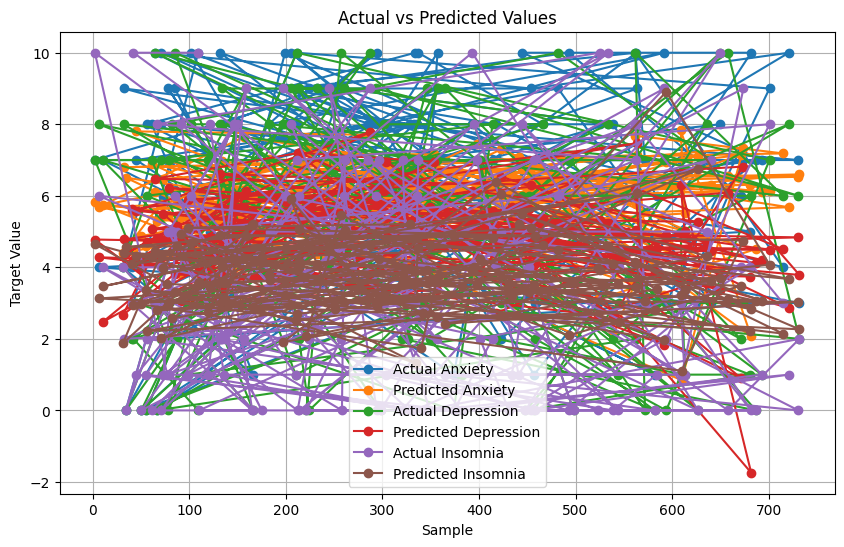

In [125]:

exclude_cols = ['Anxiety', 'Depression', 'Insomnia','OCD']
X = df_Clean[[col for col in df_Clean.columns if col not in exclude_cols]]

y = df_Clean[['Anxiety', 'Depression', 'Insomnia']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Multi Linear Regression model
multi_linear_reg = LinearRegression()
multi_linear_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = multi_linear_reg.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test['Anxiety'], marker='o', linestyle='-', label='Actual Anxiety')
plt.plot(y_test.index, y_pred[:, 0], marker='o', linestyle='-', label='Predicted Anxiety')
plt.plot(y_test.index, y_test['Depression'], marker='o', linestyle='-', label='Actual Depression')
plt.plot(y_test.index, y_pred[:, 1], marker='o', linestyle='-', label='Predicted Depression')
plt.plot(y_test.index, y_test['Insomnia'], marker='o', linestyle='-', label='Actual Insomnia')
plt.plot(y_test.index, y_pred[:, 2], marker='o', linestyle='-', label='Predicted Insomnia')
plt.xlabel('Sample')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


MSE for Anxiety: 7.208231514195954
MSE for Depression: 9.517331462232663
MSE for Insomnia: 10.218134268792689


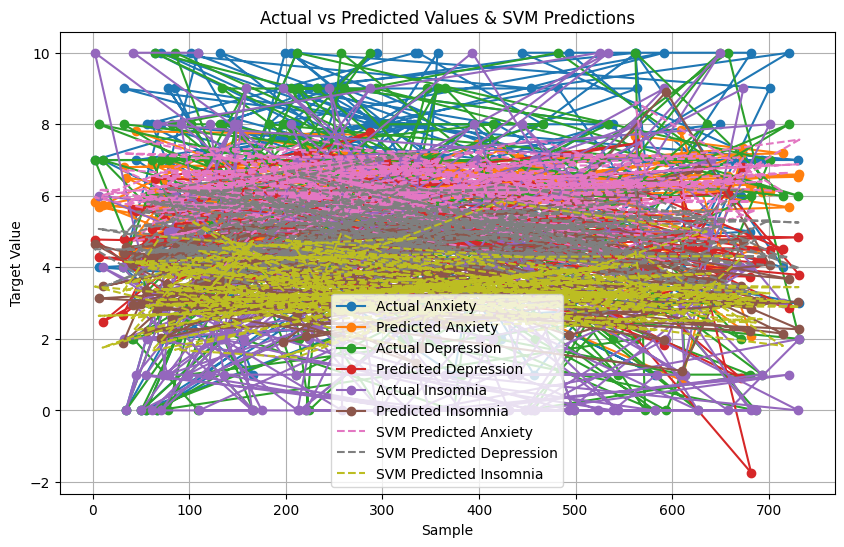

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SVR models for each target variable
svr_models = []
y_pred_svm = []

for i in range(y_train.shape[1]):  # Loop over each target variable
    svr = SVR(kernel='rbf')  # Use radial basis function (RBF) kernel for SVM
    svr.fit(X_train_scaled, y_train.iloc[:, i])  # Train SVR model for the i-th target variable
    svr_models.append(svr)  # Save the trained SVR model
    
    # Predict on the test set for the i-th target variable
    y_pred_i = svr.predict(X_test_scaled)
    y_pred_svm.append(y_pred_i)  # Collect predictions for each target variable

# Convert y_pred_svm to numpy array
y_pred_svm = np.array(y_pred_svm).T  # Transpose to match the shape of y_test

# Calculate Mean Squared Error (MSE) for each target variable
mse_svm = []
for i in range(y_test.shape[1]):  # Loop over each target variable
    mse_i = mean_squared_error(y_test.iloc[:, i], y_pred_svm[:, i])
    mse_svm.append(mse_i)

# Print Mean Squared Error (MSE) for SVM predictions
for i, column_name in enumerate(y_test.columns):
    print(f"MSE for {column_name}: {mse_svm[i]}")

# Plot actual vs predicted values (from linear regression) and SVM predictions
plt.figure(figsize=(10, 6))

# Plot actual vs predicted values from linear regression
for i, column_name in enumerate(y_test.columns):
    plt.plot(y_test.index, y_test[column_name], marker='o', linestyle='-', label=f'Actual {column_name}')
    plt.plot(y_test.index, y_pred[:, i], marker='o', linestyle='-', label=f'Predicted {column_name}')

# Plot SVM predictions
for i, column_name in enumerate(y_test.columns):
    plt.plot(y_test.index, y_pred_svm[:, i], linestyle='--', label=f'SVM Predicted {column_name}')

plt.xlabel('Sample')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values & SVM Predictions')
plt.legend()
plt.grid(True)
plt.show()


In [127]:
# MSE values for each target variable
mse_anxiety = 7.208481217071728
mse_depression = 9.517660062532252
mse_insomnia = 10.217943623526416

# Calculate the average MSE
average_mse = (mse_anxiety + mse_depression + mse_insomnia) / 3

# Print the average MSE
print(f"Average MSE: {average_mse}")


Average MSE: 8.981361634376798


In [128]:
range_anxiety = np.ptp(y_test['Anxiety'])
range_depression = np.ptp(y_test['Depression'])
range_insomnia = np.ptp(y_test['Insomnia'])

print("Range of Anxiety:", range_anxiety)
print("Range of Depression:", range_depression)
print("Range of Insomnia:", range_insomnia)

Range of Anxiety: 10.0
Range of Depression: 10.0
Range of Insomnia: 10.0


This indicates that the MLR performs very poorly. This is probably due to the high dimensional space and existence of complex relationships.

# Ensemble methods

In [129]:
df_Clean.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', '_') for col in df_Clean.columns]

In [130]:
df_Clean.columns

Index(['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer',
       'Exploratory', 'BPM', 'Frequency _Classical_', 'Frequency _Country_',
       'Frequency _EDM_', 'Frequency _Folk_', 'Frequency _Gospel_',
       'Frequency _Hip hop_', 'Frequency _Jazz_', 'Frequency _K pop_',
       'Frequency _Latin_', 'Frequency _Lofi_', 'Frequency _Metal_',
       'Frequency _Pop_', 'Frequency _R&B_', 'Frequency _Rap_',
       'Frequency _Rock_', 'Frequency _Video game music_', 'Anxiety',
       'Depression', 'Insomnia', 'OCD', 'Music effects',
       'Frequency _Classical__nor', 'Frequency _Country__nor',
       'Frequency _EDM__nor', 'Frequency _Folk__nor', 'Frequency _Gospel__nor',
       'Frequency _Hip hop__nor', 'Frequency _Jazz__nor',
       'Frequency _K pop__nor', 'Frequency _Latin__nor',
       'Frequency _Lofi__nor', 'Frequency _Metal__nor', 'Frequency _Pop__nor',
       'Frequency _R&B__nor', 'Frequency _Rap__nor', 'Frequency _Rock__nor',
       'Frequency _Video game m

In [131]:
columns_to_drop = [
    'Frequency _Classical_',
    'Frequency _Country_',
    'Frequency _EDM_',
    'Frequency _Folk_',
    'Frequency _Gospel_',
    'Frequency _Hip hop_',
    'Frequency _Jazz_',
    'Frequency _K pop_',
    'Frequency _Latin_',
    'Frequency _Lofi_',
    'Frequency _Metal_',
    'Frequency _Pop_',
    'Frequency _R&B_',
    'Frequency _Rap_',
    'Frequency _Rock_',
    'Frequency _Video game music_'
]


# Drop the specified columns
df_Clean.drop(columns=columns_to_drop, inplace=True)


In [132]:
df_Clean.columns = df_Clean.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [133]:
# Define target columns
target_columns = ['Anxiety', 'Depression', 'Insomnia', 'OCD']

# Split data into features and target
X = df_Clean.drop(target_columns, axis=1)  # Features
y = df_Clean[target_columns]  # Target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [134]:
classifiers = {
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'RandomForest': RandomForestClassifier()
}

# Initialize DataFrame to store metrics
metrics_list = []

# Fit models and calculate metrics for both train and test sets
for model_name, model in classifiers.items():
    for target in target_columns:
        # Fit model
        model.fit(X_train, y_train[target])
        
        # Predictions for train set
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train[target], y_train_pred)
        train_precision = precision_score(y_train[target], y_train_pred, average='macro')  # Specify average setting here
        train_recall = recall_score(y_train[target], y_train_pred, average='macro')  # Specify average setting here
        
        # Predictions for test set
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test[target], y_test_pred)
        test_precision = precision_score(y_test[target], y_test_pred, average='macro')  # Specify average setting here
        test_recall = recall_score(y_test[target], y_test_pred, average='macro')  # Specify average setting here
        
        # Add metrics to the list
        metrics_list.append({
            'Model': model_name,
            'Target': target,
            'Train_Accuracy': train_accuracy,
            'Train_Precision': train_precision,
            'Train_Recall': train_recall,
            'Test_Accuracy': test_accuracy,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall
        })

# Create DataFrame from the list of metrics dictionaries
metrics_df = pd.DataFrame(metrics_list)

metrics_df


c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

,Model,Target,Train_Accuracy,Train_Precision,Train_Recall,Test_Accuracy,Test_Precision,Test_Recall
0,AdaBoost,Anxiety,0.180915,0.170939,0.153333,0.115741,0.097412,0.100710
1,AdaBoost,Depression,0.190855,0.178065,0.178181,0.125000,0.097552,0.106930
2,AdaBoost,Insomnia,0.184891,0.158063,0.142035,0.115741,0.078215,0.089146
3,AdaBoost,OCD,0.322068,0.169325,0.179704,0.236111,0.072558,0.076061
4,XGBoost,Anxiety,1.000000,1.000000,1.000000,0.111111,0.085181,0.090228
5,XGBoost,Depression,1.000000,1.000000,1.000000,0.148148,0.122706,0.130511
6,XGBoost,Insomnia,1.000000,1.000000,1.000000,0.134259,0.078684,0.091554
7,XGBoost,OCD,1.000000,1.000000,1.000000,0.189815,0.068845,0.076024
8,RandomForest,Anxiety,1.000000,1.000000,1.000000,0.148148,0.113998,0.098857
9,RandomForest,Depression,1.000000,1.000000,1.000000,0.138889,0.119490,0.118415


Adaboost underfit and XGB,RF overfit

### Trying another approach with the scale converted from 0-10 to 0-3 to show severity in a more readable format

In [135]:
df_Scaledown=df_Clean.copy()

In [136]:
target_columns=['OCD','Insomnia','Depression','Anxiety']

def scale_down(value, old_min=0, old_max=10, new_min=0, new_max=3):
    old_range = old_max - old_min
    new_range = new_max - new_min
    scaled_value = (((value - old_min) * new_range) / old_range) + new_min
    return int(scaled_value)  # Convert scaled value to integer

# Apply scale_down function to target_columns in df_Scaledown
df_Scaledown[target_columns] = df_Scaledown[target_columns].apply(lambda x: x.apply(scale_down))


In [137]:
special_characters_other = X_train.columns.str.extract(r'([^a-zA-Z0-9\s_+]+)', expand=False)
special_characters_other = special_characters_other.dropna().unique()

print("Special characters found in column names other than underscore and plus sign:")
for char in special_characters_other:
    print(char)


Special characters found in column names other than underscore and plus sign:
&


In [138]:
df_Scaledown.shape

(719, 58)

In [139]:
label_mapping = {
    0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2
}

# Apply label mapping to each column in y
for col in y.columns:
    y[col] = y[col].map(label_mapping)

C:\Users\vikra\AppData\Local\Temp\ipykernel_10048\2229698281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[col] = y[col].map(label_mapping)


In [140]:
X = df_Scaledown.drop(target_columns, axis=1)  # Features
y = df_Scaledown[target_columns]  # Target


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert target variables to integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Replace special characters in column names with underscores
X_train.columns = X_train.columns.str.replace(r'[^\w\s+]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w\s+]', '_', regex=True)


classifiers = {
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'RandomForest': RandomForestClassifier(),
    'LGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(),  # Adding CatBoostClassifier
    'GBRT': GradientBoostingClassifier(),  # Adding GradientBoostingClassifier
    'ExtraTrees': ExtraTreesClassifier(),  # Adding ExtraTreesClassifier
}

# Initialize DataFrame to store metrics
metrics_list = []

# Fit models and calculate metrics for both train and test sets
for model_name, model in classifiers.items():
    for target in target_columns:
        # Fit model
        model.fit(X_train, y_train[target])
        
        # Predictions for train set
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train[target], y_train_pred)
        train_precision = precision_score(y_train[target], y_train_pred, average='macro')
        train_recall = recall_score(y_train[target], y_train_pred, average='macro')
        train_f1 = f1_score(y_train[target], y_train_pred, average='macro')  # Calculate F1 score
        train_auc_roc = roc_auc_score(y_train[target], model.predict_proba(X_train), average='macro', multi_class='ovo')  # Calculate AUC-ROC
        
        # Predictions for test set
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test[target], y_test_pred)
        test_precision = precision_score(y_test[target], y_test_pred, average='macro')
        test_recall = recall_score(y_test[target], y_test_pred, average='macro')
        test_f1 = f1_score(y_test[target], y_test_pred, average='macro')  # Calculate F1 score
        test_auc_roc = roc_auc_score(y_test[target], model.predict_proba(X_test), average='macro', multi_class='ovo')  # Calculate AUC-ROC
        
        # Add metrics to the list
        metrics_list.append({
            'Model': model_name,
            'Target': target,
            'Train_Accuracy': train_accuracy,
            'Train_Precision': train_precision,
            'Train_Recall': train_recall,
            'Train_F1_Score': train_f1,
            'Train_AUC_ROC': train_auc_roc,
            'Test_Accuracy': test_accuracy,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_F1_Score': test_f1,
            'Test_AUC_ROC': test_auc_roc
        })

# Create DataFrame from the list of metrics dictionaries
metrics_df = pd.DataFrame(metrics_list)

metrics_df

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 503, number of used features: 47
[LightGBM] [Info] Start training from score -0.377046
[LightGBM] [Info] Start training from score -1.645879
[LightGBM] [Info] Start training from score -2.328770
[LightGBM] [Info] Start training from score -3.735684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 503, number of used features: 47
[LightGBM] [Info] Start training from score -1.368560
[LightGBM] [Info] Start training from score -1.278948
[LightGBM] [Info] Start training from score -0.942476
[LightGBM] [Info] Start training from score -2.557029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate set to 0.076402
0:	learn: 1.3557841	total: 22.9ms	remaining: 22.9s
1:	learn: 1.3280536	total: 30.9ms	remaining: 15.4s
2:	learn: 1.3028452	total: 38.3ms	remaining: 12.7s
3:	learn: 1.2825940	total: 46.3ms	remaining: 11.5s
4:	learn: 1.2614770	total: 57.4ms	remaining: 11.4s
5:	learn: 1.2420458	total: 67.8ms	remaining: 11.2s
6:	learn: 1.2230526	total: 78.9ms	remaining: 11.2s
7:	learn: 1.2066598	total: 86.1ms	remaining: 10.7s
8:	learn: 1.1905522	total: 95.7ms	remaining: 10.5s
9:	learn: 1.1749939	total: 104ms	remaining: 10.3s
10:	learn: 1.1626733	total: 117ms	remaining: 10.5s
11:	learn: 1.1493131	total: 127ms	remaining: 10.5s
12:	learn: 1.1371486	total: 138ms	remaining: 10.5s
13:	learn: 1.1239383	total: 146ms	remaining: 10.3s
14:	learn: 1.1146854	total: 153ms	remaining: 10s
15:	learn: 1.1047120	total: 165ms	remaining: 10.1s
16:	learn: 1.0943863	total: 177ms	remaining: 10.2s
17:	learn: 1.0862562	total: 206ms	remaining: 11.2s
18:	learn: 1.0774300	total: 216ms	remaining: 11.2s
19:	

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate set to 0.076402
0:	learn: 1.3665331	total: 15.7ms	remaining: 15.7s
1:	learn: 1.3499960	total: 26.9ms	remaining: 13.4s
2:	learn: 1.3321746	total: 37.4ms	remaining: 12.4s
3:	learn: 1.3165550	total: 51.1ms	remaining: 12.7s
4:	learn: 1.3033946	total: 65.5ms	remaining: 13s
5:	learn: 1.2902374	total: 75.8ms	remaining: 12.6s
6:	learn: 1.2751497	total: 90.7ms	remaining: 12.9s
7:	learn: 1.2625760	total: 103ms	remaining: 12.8s
8:	learn: 1.2521460	total: 115ms	remaining: 12.7s
9:	learn: 1.2400591	total: 128ms	remaining: 12.7s
10:	learn: 1.2286015	total: 142ms	remaining: 12.7s
11:	learn: 1.2169930	total: 150ms	remaining: 12.4s
12:	learn: 1.2055373	total: 157ms	remaining: 11.9s
13:	learn: 1.1947254	total: 163ms	remaining: 11.5s
14:	learn: 1.1857196	total: 172ms	remaining: 11.3s
15:	learn: 1.1763244	total: 184ms	remaining: 11.3s
16:	learn: 1.1663649	total: 192ms	remaining: 11.1s
17:	learn: 1.1588523	total: 201ms	remaining: 11s
18:	learn: 1.1494700	total: 213ms	remaining: 11s
19:	learn:

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate set to 0.076402
0:	learn: 1.3664580	total: 15.8ms	remaining: 15.7s
1:	learn: 1.3515728	total: 27.5ms	remaining: 13.7s
2:	learn: 1.3372127	total: 38.5ms	remaining: 12.8s
3:	learn: 1.3219623	total: 48.1ms	remaining: 12s
4:	learn: 1.3040524	total: 57.2ms	remaining: 11.4s
5:	learn: 1.2896676	total: 66.9ms	remaining: 11.1s
6:	learn: 1.2756246	total: 76.6ms	remaining: 10.9s
7:	learn: 1.2604357	total: 86.6ms	remaining: 10.7s
8:	learn: 1.2506865	total: 95.8ms	remaining: 10.5s
9:	learn: 1.2393321	total: 105ms	remaining: 10.4s
10:	learn: 1.2298059	total: 117ms	remaining: 10.5s
11:	learn: 1.2198563	total: 130ms	remaining: 10.7s
12:	learn: 1.2105229	total: 142ms	remaining: 10.7s
13:	learn: 1.1994770	total: 150ms	remaining: 10.5s
14:	learn: 1.1892525	total: 159ms	remaining: 10.4s
15:	learn: 1.1788776	total: 166ms	remaining: 10.2s
16:	learn: 1.1714528	total: 177ms	remaining: 10.2s
17:	learn: 1.1642317	total: 186ms	remaining: 10.2s
18:	learn: 1.1563709	total: 194ms	remaining: 10s
19:	le

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

,Model,Target,Train_Accuracy,Train_Precision,Train_Recall,Train_F1_Score,Train_AUC_ROC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1_Score,Test_AUC_ROC
0,AdaBoost,OCD,0.656064,0.430777,0.373694,0.382703,0.770312,0.564815,0.208260,0.226896,0.212568,0.457432
1,AdaBoost,Insomnia,0.495030,0.474256,0.374250,0.399392,0.740860,0.425926,0.251637,0.260055,0.253548,0.491368
2,AdaBoost,Depression,0.487078,0.553400,0.465812,0.492855,0.764016,0.337963,0.323531,0.303046,0.301503,0.608268
3,AdaBoost,Anxiety,0.467197,0.496182,0.398627,0.414600,0.780616,0.347222,0.244957,0.274071,0.258622,0.542855
4,XGBoost,OCD,1.000000,1.000000,1.000000,1.000000,1.000000,0.634259,0.311080,0.247537,0.223512,0.476091
5,XGBoost,Insomnia,1.000000,1.000000,1.000000,1.000000,1.000000,0.490741,0.278732,0.289844,0.279704,0.530132
6,XGBoost,Depression,1.000000,1.000000,1.000000,1.000000,1.000000,0.337963,0.265494,0.270812,0.258845,0.548480
7,XGBoost,Anxiety,1.000000,1.000000,1.000000,1.000000,1.000000,0.388889,0.283918,0.317843,0.299903,0.539092
8,RandomForest,OCD,1.000000,1.000000,1.000000,1.000000,1.000000,0.671296,0.168605,0.248288,0.200831,0.494463
9,RandomForest,Insomnia,1.000000,1.000000,1.000000,1.000000,1.000000,0.527778,0.278212,0.267377,0.233708,0.521107


- Overfit = XGB,RF,LGBM,CatBoost,ExtraTrees, GBM
- Underfit = AdaBoost

# Using optuna on Random Forest

In [ ]:
# Define target columns
target_columns = ['Anxiety', 'Depression', 'Insomnia', 'OCD']

# Split data into features and target
X = df_Scaledown.drop(target_columns, axis=1)  # Features
y = df_Scaledown[target_columns]  # Target

# Split data into train and validation sets (70% train, 15% test, 15% validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert target variables to integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# Replace special characters in column names with underscores
X_train.columns = X_train.columns.str.replace(r'[^\w\s+]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w\s+]', '_', regex=True)
X_val.columns = X_val.columns.str.replace(r'[^\w\s+]', '_', regex=True)


In [42]:


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_uniform('max_features', 0.6, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train[target], cv=5)
    return cv_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train[target])

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
val_pred = model.predict(X_val)  

train_accuracy = accuracy_score(y_train[target], train_pred)
train_precision = precision_score(y_train[target], train_pred, average='macro')
train_recall = recall_score(y_train[target], train_pred, average='macro')
train_f1 = f1_score(y_train[target], train_pred, average='macro')
train_auc_roc = roc_auc_score(y_train[target], model.predict_proba(X_train), average='macro', multi_class='ovo')

test_accuracy = accuracy_score(y_test[target], test_pred)
test_precision = precision_score(y_test[target], test_pred, average='macro')
test_recall = recall_score(y_test[target], test_pred, average='macro')
test_f1 = f1_score(y_test[target], test_pred, average='macro')
test_auc_roc = roc_auc_score(y_test[target], model.predict_proba(X_test), average='macro', multi_class='ovo')

val_accuracy = accuracy_score(y_val[target], val_pred)
val_precision = precision_score(y_val[target], val_pred, average='macro')
val_recall = recall_score(y_val[target], val_pred, average='macro')
val_f1 = f1_score(y_val[target], val_pred, average='macro')
val_auc_roc = roc_auc_score(y_val[target], model.predict_proba(X_val), average='macro', multi_class='ovo')

# Display scores
print("Train Set Scores:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print(f"AUC-ROC Score: {train_auc_roc}")

print("\nTest Set Scores:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(f"AUC-ROC Score: {test_auc_roc}")

print("\nValidation Set Scores:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1 Score: {val_f1}")
print(f"AUC-ROC Score: {val_auc_roc}")

[I 2024-05-01 22:33:23,041] A new study created in memory with name: no-name-bd28773e-24f6-492a-90f6-d1de02db5bb5
C:\Users\vikra\AppData\Local\Temp\ipykernel_27532\1945389403.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 50, 200, 50),
C:\Users\vikra\AppData\Local\Temp\ipykernel_27532\1945389403.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_features': trial.suggest_uniform('max_features', 0.6, 1.0),
[I 2024-05-01 22:33:26,365] Trial 0 finished with value: 0.6920236055587283 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.6595613805133395, 'bootstrap': True}. Best is trial 0 with value: 0.6920236055587283.
C:\Users\vikra\AppData\Local

Train Set Scores:
Accuracy: 0.6998050682261209
Precision: 0.42436149312377214
Recall: 0.260752688172043
F1 Score: 0.22605837151584574
AUC-ROC Score: 0.9455727699530515

Test Set Scores:
Accuracy: 0.6272727272727273
Precision: 0.15681818181818183
Recall: 0.25
F1 Score: 0.19273743016759776
AUC-ROC Score: 0.42940318035426733

Validation Set Scores:
Accuracy: 0.7027027027027027
Precision: 0.17567567567567569
Recall: 0.25
F1 Score: 0.20634920634920637
AUC-ROC Score: 0.5800094966761633


c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
best_params

{'n_estimators': 50,
 'max_depth': 5,
 'min_samples_split': 15,
 'min_samples_leaf': 7,
 'max_features': 0.7983833329145383,
 'bootstrap': True}

# Using optuna on GBM

In [72]:
X_train["Foreign languages_Yes"].value_counts()

Foreign languages_Yes
1.0    279
0.0    234
Name: count, dtype: int64

In [69]:
X_train.columns

Index(['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer',
       'Exploratory', 'BPM', 'Music effects', 'Frequency _Classical__nor',
       'Frequency _Country__nor', 'Frequency _EDM__nor',
       'Frequency _Folk__nor', 'Frequency _Gospel__nor',
       'Frequency _Hip hop__nor', 'Frequency _Jazz__nor',
       'Frequency _K pop__nor', 'Frequency _Latin__nor',
       'Frequency _Lofi__nor', 'Frequency _Metal__nor', 'Frequency _Pop__nor',
       'Frequency _R_B__nor', 'Frequency _Rap__nor', 'Frequency _Rock__nor',
       'Frequency _Video game music__nor', 'weighted_danceability',
       'weighted_energy', 'weighted_loudness', 'weighted_mode',
       'weighted_speechiness', 'weighted_acousticness',
       'weighted_instrumentalness', 'weighted_liveness', 'weighted_valence',
       'weighted_metric_depression', 'weighted_metric_anxiety',
       'weighted_metric_ocd', 'weighted_metric_insomnia',
       'Foreign languages_Yes', 'Fav genre_Classical', 'Fav genre_Country'

In [179]:
df_Scaledown.to_csv(r"C:\Users\vikra\Documents\5153\XAI\df_clean_Scaledown.csv")

In [178]:
df_Scaledown["Anxiety"].value_counts()

Anxiety
2    294
1    196
0    177
3     67
Name: count, dtype: int64

In [174]:
# Define target columns
target_columns = ['Anxiety', 'Depression', 'Insomnia', 'OCD']

# Split data into features and target
X = df_Clean.drop(target_columns, axis=1)  # Features
y = df_Clean[target_columns]  # Target

# Split data into train and validation sets (70% train, 15% test, 15% validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert target variables to integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# Replace special characters in column names with underscores
X_train.columns = X_train.columns.str.replace(r'[^\w\s+]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w\s+]', '_', regex=True)
X_val.columns = X_val.columns.str.replace(r'[^\w\s+]', '_', regex=True)


In [66]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'max_features': trial.suggest_uniform('max_features', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 42  # Fixed random state for reproducibility
    }
    
    model = GradientBoostingClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train[target], cv=5)
    return cv_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

model = GradientBoostingClassifier(**best_params)
model.fit(X_train, y_train[target])

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
val_pred = model.predict(X_val)  

train_accuracy = accuracy_score(y_train[target], train_pred)
train_precision = precision_score(y_train[target], train_pred, average='macro')
train_recall = recall_score(y_train[target], train_pred, average='macro')
train_f1 = f1_score(y_train[target], train_pred, average='macro')
train_auc_roc = roc_auc_score(y_train[target], model.predict_proba(X_train), average='macro', multi_class='ovo')

test_accuracy = accuracy_score(y_test[target], test_pred)
test_precision = precision_score(y_test[target], test_pred, average='macro')
test_recall = recall_score(y_test[target], test_pred, average='macro')
test_f1 = f1_score(y_test[target], test_pred, average='macro')
test_auc_roc = roc_auc_score(y_test[target], model.predict_proba(X_test), average='macro', multi_class='ovo')

val_accuracy = accuracy_score(y_val[target], val_pred)
val_precision = precision_score(y_val[target], val_pred, average='macro')
val_recall = recall_score(y_val[target], val_pred, average='macro')
val_f1 = f1_score(y_val[target], val_pred, average='macro')
val_auc_roc = roc_auc_score(y_val[target], model.predict_proba(X_val), average='macro', multi_class='ovo')

# Display scores
print("Train Set Scores:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print(f"AUC-ROC Score: {train_auc_roc}")

print("\nTest Set Scores:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(f"AUC-ROC Score: {test_auc_roc}")

print("\nValidation Set Scores:")
print(f"Accuracy: {val_accuracy}")
print(f"Precision: {val_precision}")
print(f"Recall: {val_recall}")
print(f"F1 Score: {val_f1}")
print(f"AUC-ROC Score: {val_auc_roc}")


[I 2024-05-03 09:30:57,766] A new study created in memory with name: no-name-b06fbdbd-f08c-42dd-9e61-2559f2af1294
C:\Users\vikra\AppData\Local\Temp\ipykernel_35496\2572426549.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 50, 200, 50),
C:\Users\vikra\AppData\Local\Temp\ipykernel_35496\2572426549.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\vikra\AppData\Local\Temp\ipykernel_35496\2572426549.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_un

Train Set Scores:
Accuracy: 0.8713450292397661
Precision: 0.9763779527559056
Recall: 0.8372577975129463
F1 Score: 0.8952203293785275
AUC-ROC Score: 0.9999785841942386

Test Set Scores:
Accuracy: 0.2727272727272727
Precision: 0.08484848484848485
Recall: 0.09494949494949495
F1 Score: 0.05502645502645503
AUC-ROC Score: 0.4873889399040913

Validation Set Scores:
Accuracy: 0.2702702702702703
Precision: 0.025020850708924104
Recall: 0.09090909090909091
F1 Score: 0.03924133420536298
AUC-ROC Score: 0.5554039201539201


c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
study.best_params

{'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.01406235974348568,
 'subsample': 0.6041048627531311,
 'max_features': 0.7582181029284326,
 'min_samples_split': 9,
 'min_samples_leaf': 4}

In [68]:
# saving this a a joblib

import joblib
best_params = study.best_params

# Initialize and train the final model with the best hyperparameters
final_model = GradientBoostingClassifier(**best_params)
final_model.fit(X_train, y_train[target])

# Save the trained model as a joblib file
joblib.dump(final_model, r'C:\Users\vikra\Documents\5153\GBmodel.joblib')

['C:\\Users\\vikra\\Documents\\5153\\GBmodel.joblib']

In [76]:
test_df=pd.read_csv(r"C:\Users\vikra\Documents\5153\Testing\testDataFinal2.csv")

In [77]:
final_model.predict(test_df)

array([2, 0])

# None of the models are able to properly predict the impact on mental health on such a small granularity.
- This could be due to less quantity of data
- not enough meaningfull relationships on this granularity

## We can check if listening to specific music alleviates their conditions however (Music effects)

In [48]:
target_columns=["Music effects"]

X = df_Clean.drop(target_columns, axis=1)  # Features
y = df_Clean[target_columns]  # Target

Old_targets = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
X = X.drop(Old_targets, axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert target variables to integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Replace special characters in column names with underscores
X_train.columns = X_train.columns.str.replace(r'[^\w\s+]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w\s+]', '_', regex=True)

In [49]:
y.value_counts()

Music effects
0.0              530
1.0              164
2.0               17
3.0                8
Name: count, dtype: int64

In [50]:
classifiers = {
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'RandomForest': RandomForestClassifier(),
    'LGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(),  # Adding CatBoostClassifier
    'ExtraTrees': ExtraTreesClassifier(),  # Adding ExtraTreesClassifier
    'GBM': GradientBoostingClassifier()  # Adding GradientBoostingClassifier as GBM
}

# Initialize DataFrame to store metrics
metrics_list = []

# Fit models and calculate metrics for both train and test sets
for model_name, model in classifiers.items():
    for target in target_columns:
        # Fit model
        model.fit(X_train, y_train[target])
        
        # Predictions for train set
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train[target], y_train_pred)
        train_precision = precision_score(y_train[target], y_train_pred, average='macro')
        train_recall = recall_score(y_train[target], y_train_pred, average='macro')
        train_f1 = f1_score(y_train[target], y_train_pred, average='macro')  # Calculate F1 score
        train_auc_roc = roc_auc_score(y_train[target], model.predict_proba(X_train), average='macro', multi_class='ovo')  # Calculate AUC-ROC
        
        # Predictions for test set
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test[target], y_test_pred)
        test_precision = precision_score(y_test[target], y_test_pred, average='macro')
        test_recall = recall_score(y_test[target], y_test_pred, average='macro')
        test_f1 = f1_score(y_test[target], y_test_pred, average='macro')  # Calculate F1 score
        test_auc_roc = roc_auc_score(y_test[target], model.predict_proba(X_test), average='macro', multi_class='ovo')  # Calculate AUC-ROC
        
        # Add metrics to the list
        metrics_list.append({
            'Model': model_name,
            'Target': target,
            'Train_Accuracy': train_accuracy,
            'Train_Precision': train_precision,
            'Train_Recall': train_recall,
            'Train_F1_Score': train_f1,
            'Train_AUC_ROC': train_auc_roc,
            'Test_Accuracy': test_accuracy,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_F1_Score': test_f1,
            'Test_AUC_ROC': test_auc_roc
        })

# Create DataFrame from the list of metrics dictionaries
metrics_df = pd.DataFrame(metrics_list)

metrics_df

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 503, number of used features: 46
[LightGBM] [Info] Start training from score -0.293664
[LightGBM] [Info] Start training from score -1.538459
[LightGBM] [Info] Start training from score -3.655641
[LightGBM] [Info] Start training from score -4.274680
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Learning rate set to 0.076402
0:	learn: 1.3060212	total: 158ms	remaining: 2m 38s
1:	learn: 1.2374735	total: 164ms	remaining: 1m 21s
2:	learn: 1.1730768	total: 172ms	remaining: 57.1s
3:	learn: 1.1185765	total: 180ms	remaining: 44.8s
4:	learn: 1.0784291	total: 185ms	remaining: 36.9s
5:	learn: 1.0402653	total: 190ms	remaining: 31.5s
6:	learn: 1.0045685	total: 195ms	remaining: 27.6s
7:	learn: 0.9717269	total: 199ms	remaining: 24.6s
8:	learn: 0.9448366	total: 203ms	remaining: 22.3s
9:	learn: 0.9212680	total: 207ms	remaining: 20.5s
10:	learn: 0.8989685	total: 211ms	remaining: 18.9s
11:	learn: 0.8764130	total: 214ms	remaining: 17.6s
12:	learn: 0.8545237	total: 218ms	remaining: 16.5s
13:	learn: 0.8360749	total: 222ms	remaining: 15.7s
14:	learn: 0.8209334	total: 226ms	remaining: 14.9s
15:	learn: 0.8071521	total: 230ms	remaining: 14.2s
16:	learn: 0.7907633	total: 234ms	remaining: 13.5s
17:	learn: 0.7784147	total: 249ms	remaining: 13.6s
18:	learn: 0.7658540	total: 253ms	remaining: 13.1s
19:	learn

c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vikra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Target,Train_Accuracy,Train_Precision,Train_Recall,Train_F1_Score,Train_AUC_ROC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1_Score,Test_AUC_ROC
0,AdaBoost,Music effects,0.568588,0.533094,0.390276,0.357121,0.803616,0.527778,0.279040,0.198128,0.215508,0.341213
1,XGBoost,Music effects,1.000000,1.000000,1.000000,1.000000,1.000000,0.689815,0.253922,0.248877,0.226070,0.382546
2,RandomForest,Music effects,1.000000,1.000000,1.000000,1.000000,1.000000,0.703704,0.178404,0.245161,0.206522,0.341676
3,LGBM,Music effects,1.000000,1.000000,1.000000,1.000000,1.000000,0.708333,0.308081,0.269585,0.260938,0.379313
4,CatBoost,Music effects,1.000000,1.000000,1.000000,1.000000,1.000000,0.689815,0.241422,0.248877,0.225401,0.507721
5,GBRT,Music effects,0.996024,0.998674,0.995370,0.996999,1.000000,0.694444,0.265264,0.250490,0.228959,0.424866
6,ExtraTrees,Music effects,1.000000,1.000000,1.000000,1.000000,1.000000,0.717593,0.306490,0.261406,0.239239,0.472315
7,GBM,Music effects,0.998012,0.999335,0.997685,0.998504,1.000000,0.685185,0.249432,0.247264,0.226613,0.403643
